In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import gpxSense as gpx
import matplotlib.pyplot as plt

2025-02-09 13:31:24.242817: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 13:31:24.243223: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 13:31:24.246564: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 13:31:24.257366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739104284.276007    7508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739104284.28

<class 'pandas.core.frame.DataFrame'>
Index: 6073 entries, 0 to 531
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ele       6073 non-null   float64
 1   hr        6073 non-null   float64
 2   cad       6073 non-null   float64
 3   dist      6073 non-null   float64
 4   time_acc  6073 non-null   float64
 5   pace      6073 non-null   float64
dtypes: float64(6)
memory usage: 332.1 KB
None
ele           38.432323
hr           153.724518
cad          178.290960
dist        4099.041451
time_acc      25.962660
pace           6.197837
dtype: float64
6073


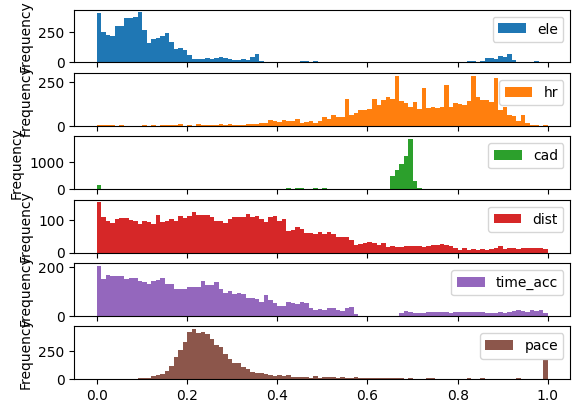

In [3]:
df1 = gpx.gpxAnalyseClass("Data/31-05-2024.gpx").df
df2 = gpx.gpxAnalyseClass("Data/05-06-2024.gpx").df
df3 = gpx.gpxAnalyseClass("Data/18-06-2024.gpx").df
df4 = gpx.gpxAnalyseClass("Data/11-07-2024.gpx").df
df5 = gpx.gpxAnalyseClass("Data/07-12-2024.gpx").df
df6 = gpx.gpxAnalyseClass("Data/09-01-2025.gpx").df
df7 = gpx.gpxAnalyseClass("Data/23-01-2025.gpx").df
df8 = gpx.gpxAnalyseClass("Data/29-01-2025.gpx").df
df9 = gpx.gpxAnalyseClass("Data/31-01-2025.gpx").df
df10 = gpx.gpxAnalyseClass("Data/04-02-2025.gpx").df
df11 = gpx.gpxAnalyseClass("Data/07-02-2025.gpx").df

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df11], axis=0)
df = df.drop(['lat', 'lon'], axis=1)
df = df.select_dtypes(include=['number'])
print(df.info())
print(df.mean())
print(len(df))
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm.plot(kind='hist', bins=100, subplots=True, sharey=False)
df_norm = df_norm.sample(frac=1)

In [4]:

def huber_loss(y_true, y_pred, clip_delta=1.0):
	error = y_true - y_pred
	cond  = tf.keras.backend.abs(error) < clip_delta

	squared_loss = 0.5 * tf.keras.backend.square(error)
	linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

	return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
	return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def combined_loss(alpha):
    def loss(y_true, y_pred):
        mse = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred))
        mae = tf.keras.backend.mean(tf.keras.backend.abs(y_true - y_pred))
        return alpha * mse + (1 - alpha) * mae
    return loss

def from_df_to_tfds(df, y, shuffle=True, batch_size=32):
	ds = tf.data.Dataset.from_tensor_slices((df.values, y.values))
	if shuffle:
		ds = ds.shuffle(buffer_size=len(df))
	ds = ds.batch(batch_size)
	return ds

def performance(model, df_train, df_norm_test, y_test):
	evaluations = model.evaluate(from_df_to_tfds(df_norm_test, y_test, shuffle=False, batch_size=1))
	print(model.predict(from_df_to_tfds(df_norm_test, y_test, shuffle=False, batch_size=1)).mean() * (df.max()['hr'] - df.min()['hr']) + df.min()['hr'])
	print(y_test.mean() * (df_train.max()['hr'] - df_train.min()['hr']) + df_train.min()['hr'])
	print(evaluations)
	print((evaluations[0] * (df_train['hr'].max() - df_train['hr'].min())))
	print((evaluations[1] * (df_train['hr'].max() - df_train['hr'].min())))
	print(f"The percentage of error is: " f"{(evaluations[1]) * 100 : .2f}" + f"%")

In [ ]:
df_train = df_norm.iloc[:int(df_norm.shape[0] * 0.8)]
df_val = df_norm.iloc[int(df_norm.shape[0] * 0.8):]
y_train = df_train.pop('hr')
y_val = df_val.pop('hr')

batch_size = 32
l2 = 5e-6
lr = 6.5e-4


num_features = df_train.shape[1]

inputs = tf.keras.layers.Input(shape=(num_features,))

""" x = tf.keras.layers.Dense(128, activation='leaky_relu',
						  kernel_regularizer=tf.keras.regularizers.l2(0.0001)
						  )(inputs)
x = tf.keras.layers.Dense(64, activation='relu',
						  kernel_regularizer=tf.keras.regularizers.l2(0.0001)
						  )(x) """
x = tf.keras.layers.Dense(64, activation='leaky_relu',
						  kernel_regularizer=tf.keras.regularizers.l2(l2)
						  )(inputs)
x = tf.keras.layers.Dense(32, activation='relu',
						  kernel_regularizer=tf.keras.regularizers.l2(l2)
						  )(x)
x = tf.keras.layers.Dense(16, activation='relu',
						  kernel_regularizer=tf.keras.regularizers.l2(l2)
						  )(x)

outputs = tf.keras.layers.Dense(1)(x)

DNNmodel = tf.keras.models.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr)

ds_train = from_df_to_tfds(df_train, y_train, batch_size=batch_size)
ds_val = from_df_to_tfds(df_val, y_val, batch_size=batch_size)

DNNmodel.compile(optimizer=optimizer, loss=huber_loss_mean, metrics=['mae'])

DNNmodel.summary()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = DNNmodel.fit(ds_train, validation_data=ds_val, epochs=250, callbacks=callbacks)
history_df = pd.DataFrame(history.history)
with open('history.csv', mode='w') as f:
	history_df.to_csv(f)
DNNmodel.save('DNNmodelPruebas.keras')


AttributeError: '_BatchDataset' object has no attribute 'values'

1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
160.7587878704071
160.2091743119266
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.0052 - mae: 0.0810
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


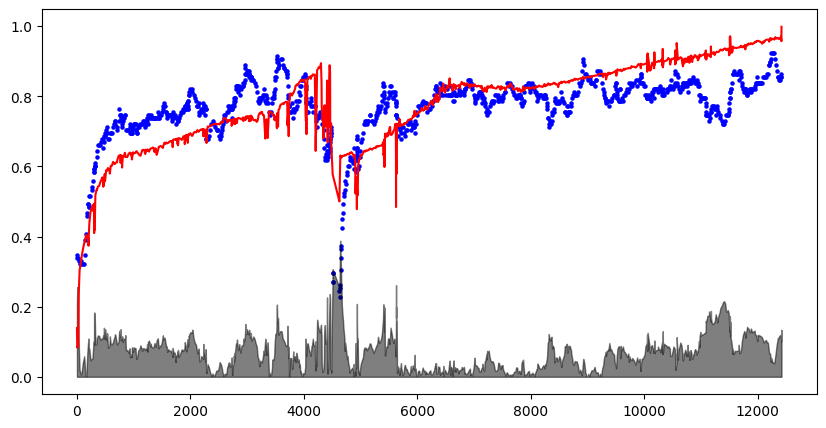

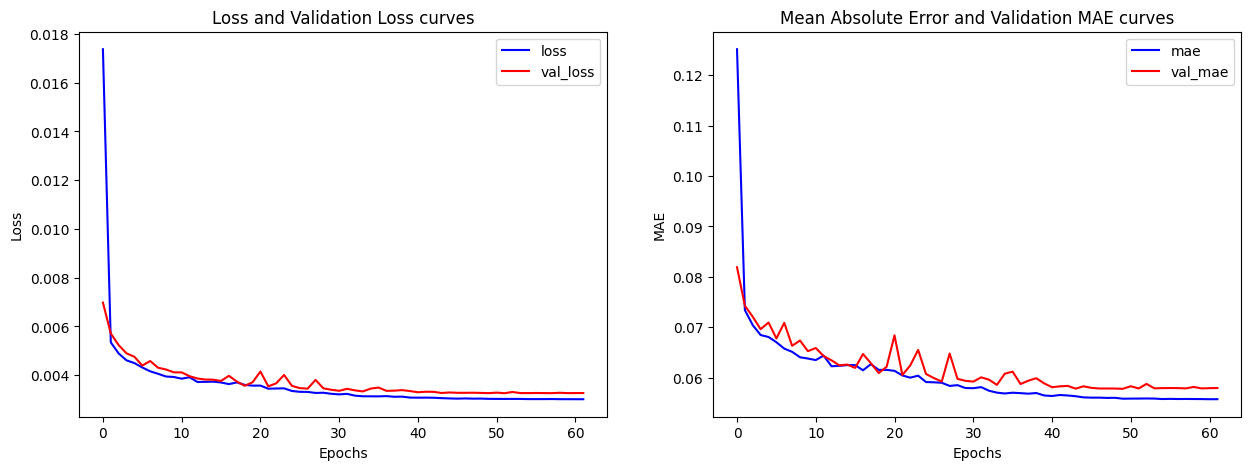

In [6]:
DNNmodel = tf.keras.models.load_model('DNNHBRMEANBS32LN00065LR1e-5L2.keras', custom_objects={'huber_loss_mean': huber_loss_mean})
gpxTest = gpx.LinearPredictor("Data/25-01-2024_Test3.gpx")
df_test = gpxTest.df
df_norm_test = df_test.drop(['lat', 'lon'], axis=1)
df_norm_test = df_norm_test.select_dtypes(include=['number'])
df_norm_test = (df_norm_test - df.min()) / (df.max() - df.min())
#df_norm_test = df_norm_test.loc[df_norm_test['hr'] > 0.65 * df_norm_test['hr'].max()]
y_test = df_norm_test.pop('hr')
#gpxTest.plot_predictions(model=DNNmodel, df_test_norm=gpxTest.df_norm, df_test=gpxTest.df)
print(DNNmodel.predict(from_df_to_tfds(df_norm_test, y_test, shuffle=False, batch_size=1)).mean() * (df.max()['hr'] - df.min()['hr']) + df.min()['hr'])
print(y_test.mean() * (df.max()['hr'] - df.min()['hr']) + df.min()['hr'])
DNNmodel.evaluate(from_df_to_tfds(df_norm_test, y_test, shuffle=False, batch_size=1))
#gpxTest.plot_predictions(DNNmodel, gpxTest.df_norm, gpxTest.df)
predictions = DNNmodel.predict(from_df_to_tfds(df_norm_test, y_test, shuffle=False))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(df_test['dist'], y_test, s=5, color='b', label='Real values')
ax.plot(df_test['dist'], predictions, color='r', label='Predicted values')
MAE = abs(y_test.values - np.transpose(predictions))[0]
ax.fill_between(df_test['dist'], MAE.min(), MAE, color='k', alpha=.5)
gpxTest.plot_performance(history)

In [7]:
performance(DNNmodel, df, df_norm_test, y_test)


   1/1090 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0222 - mae: 0.2083

1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 0.0052 - mae: 0.0810
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step
160.7587878704071
160.2091743119266
[0.004700257442891598, 0.07467170059680939]
0.5546303782612085
8.811260670423508
The percentage of error is:  7.47%
